In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%load_ext skip_cell

In [3]:
IMPATIENCE = True

We start from features extracted with `ResNet18` (pretrained on `ImageNet`).

In [4]:
X, y = np.load('../data/X_resnet18.npy'), np.load('../data/y_resnet18.npy')

## PCA

We have started from ***principal components analysis***. PCA encodes data to represent a lower-dimensional version of them. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components.

In [5]:
from sklearn.decomposition import PCA

pca = PCA().fit(X)
X_pca_projection = pca.transform(X)

The total variance is the sum of variances of all individual principal components. We observed that 100 componenets explained nearly $80\%$ of total variance. This information will be useful when we will be performing applying `t-SNE` to our data.

[Text(0, 0.5, 'Explained variance'), Text(0.5, 0, 'Number of components')]

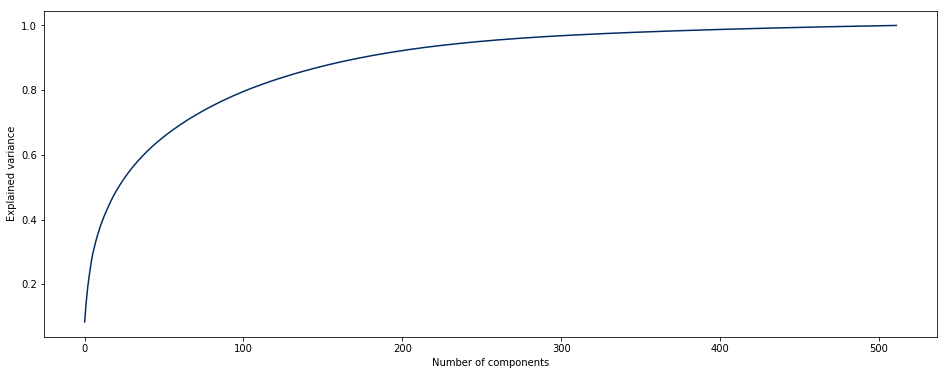

In [6]:
f, ax = plt.subplots(figsize=(16, 6))
ax.plot(np.cumsum(pca.explained_variance_ratio_), c='#032C64')
ax.set(xlabel='Number of components', ylabel='Explained variance')

But first, we have visualized first two components.

In [7]:
LABELS = [
    'bird', 'boat', 'cat', 'dog', 'flower', 'frog',
    'jumbojet', 'mushroom', 'sportscar', 'tree'
]
map_labels = {key: value for key, value in enumerate(LABELS)}

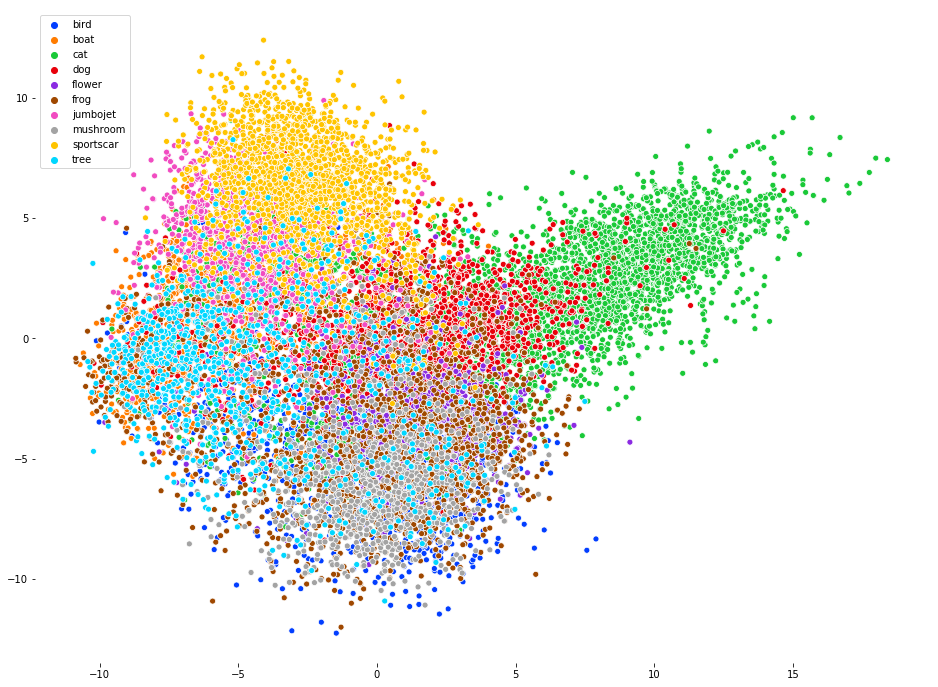

In [8]:
import seaborn as sns

f, ax = plt.subplots(figsize=(16, 12))
sns.despine(left=True, bottom=True)
sns.scatterplot(
    x=X_pca_projection[:, 0],
    y=X_pca_projection[:, 1],
    hue=list(map(lambda x: map_labels[x], y)),
    palette=sns.color_palette('bright', 10),
    ax=ax
)

## t-SNE

`t-SNE` is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. The `t-SNE` algorithm comprises two main stages. First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects have a high probability of being picked, whilst dissimilar points have an extremely small probability of being picked. Second, t-SNE defines a similar probability distribution over the points in the low-dimensional map, and it minimizes the Kullback–Leibler divergence between the two distributions with respect to the locations of the points in the map.

In original paper which introduced `t-SNE` authors started by using `PCA` to reduce dimensionality of the data to 30. They argued that: *This speeds up the computation of pairwise distances between the datapoints and supresses some noise without severely distorting the interpoint distances*. We decided to use PCA with `n_components` set to `100` (this value was choosen after analysis of relationship between number of componenets and percentage of explained variance).

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pipe_tsne = Pipeline(steps=[
    ('pca', PCA(n_components=100)),
    ('tsne', TSNE(n_components=2, random_state=42))
])

Then, we applied `t-SNE` with different values of `perplexity`. Perplexity can be interpreted as a smooth measure of the effective number of neighbors. We have tried perplexity values in the range `[5, 50]` which were suggested by van der Maaten and Hinton.

In [10]:
%%skip $IMPATIENCE
X_tsne = dict()
for perplexity in [5, 30, 50]:
    X_tsne[perplexity] = pipe_tsne.set_params(tsne__perplexity=perplexity)\
        .fit_transform(X)
# save embeddings
with open('../data/X_tsne.p', 'wb') as tsne:
    pickle.dump(X_tsne, tsne)

Load embeddings from disk.

In [11]:
with open('../data/X_tsne.p', 'rb') as tsne:
    X_tsne = pickle.load(tsne)

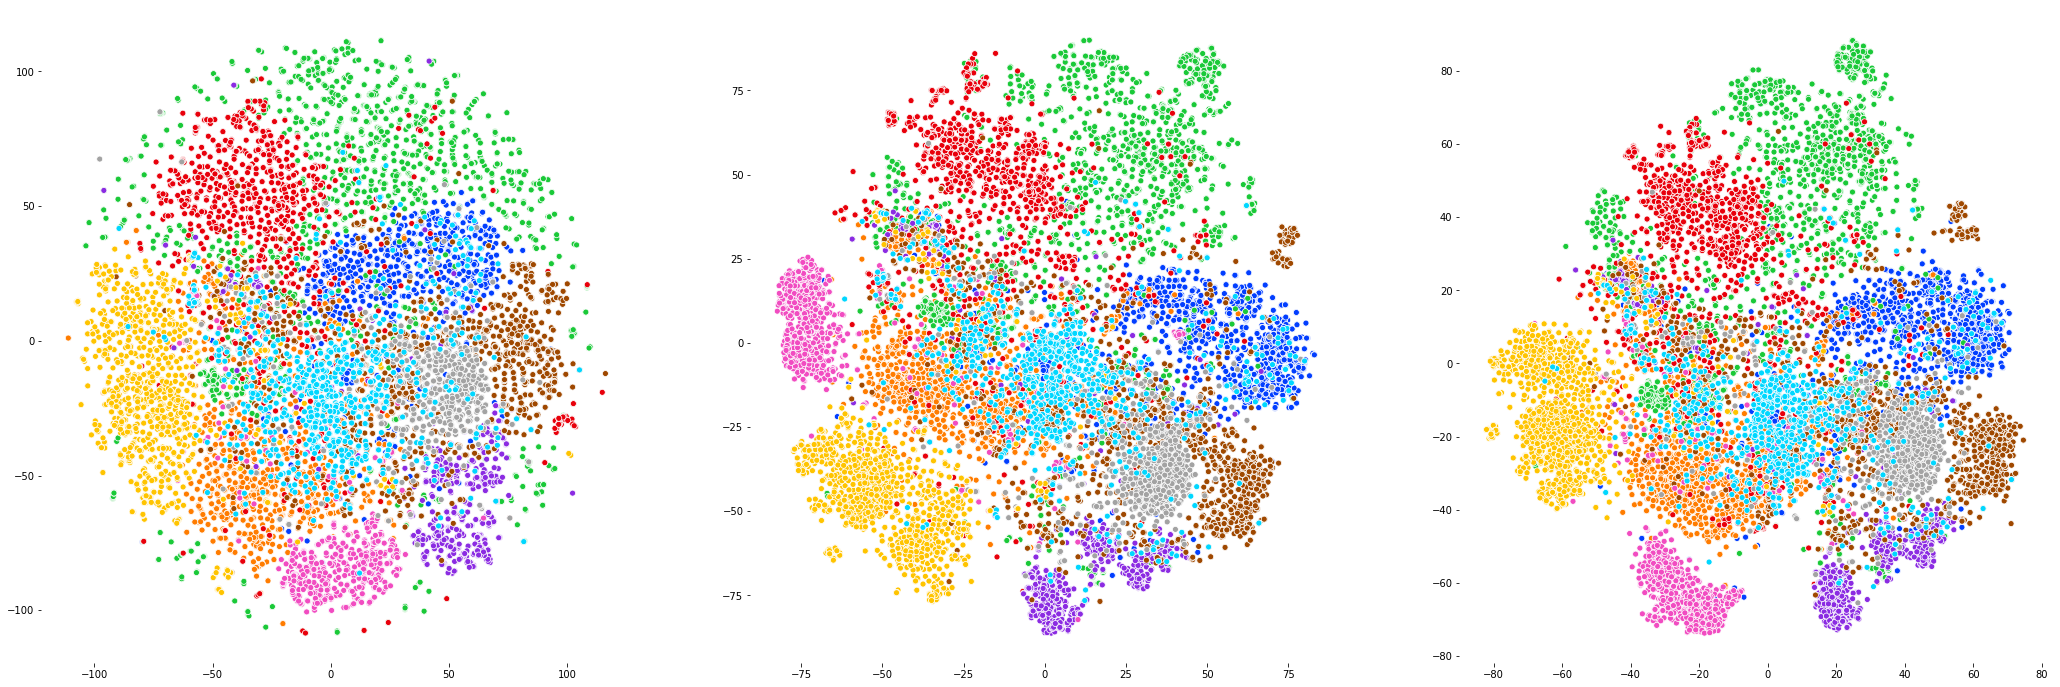

In [12]:
f, ax = plt.subplots(figsize=(36, 12), ncols=3)
for i, (perplexity, embeddings) in enumerate(X_tsne.items()):
    sns.despine(left=True, bottom=True)
    sns.scatterplot(
        x=embeddings[:, 0],
        y=embeddings[:, 1],
        hue=list(map(lambda x: map_labels[x], y)),
        palette=sns.color_palette('bright', 10),
        legend=False,
        ax=ax[i]
    )

We observed that the entities from categories that were easily classified with *shallow classifier* are well separated from other classes in two-dimensional visualization based on feature vectors extracted with ResNet18.

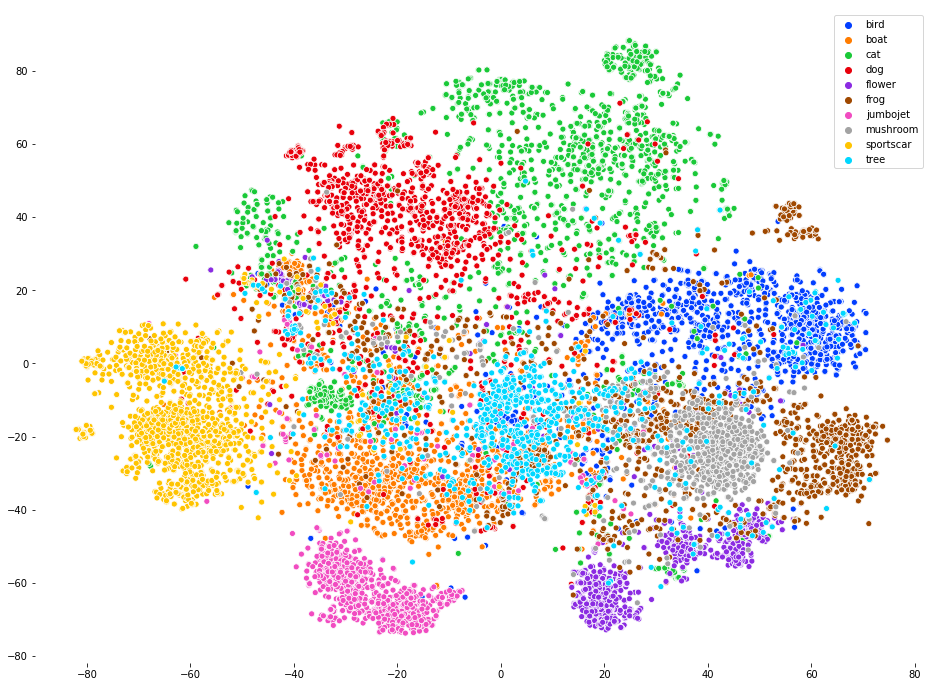

In [13]:
f, ax = plt.subplots(figsize=(16, 12))
sns.despine(left=True, bottom=True)
sns.scatterplot(
    x=X_tsne[50][:, 0],
    y=X_tsne[50][:, 1],
    hue=list(map(lambda x: map_labels[x], y)),
    palette=sns.color_palette('bright', 10),
    ax=ax
)

## UMAP

Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data:

* the data is uniformly distributed on a Riemannian manifold,
* the Riemannian metric is locally constant (or can be approximated as such),
* the manifold is locally connected.

From these assumptions it is possible to model the manifold with a fuzzy topological structure. The embedding is found by searching for a low dimensional projection of the data that has the closest possible equivalent fuzzy topological structure [[2](https://github.com/lmcinnes/umap)].

We applied `UMAP` for grid of hyperparameters suggested by its authors. According to documentation:

* `n_neighbors`: This determines the number of neighboring points used in local approximations of manifold structure. Larger values will result in more global structure being preserved at the loss of detailed local structure. In general this parameter should often be in the range 5 to 50, with a choice of 10 to 15 being a sensible default.
* `min_dist`: This controls how tightly the embedding is allowed compress points together. Larger values ensure embedded points are more evenly distributed, while smaller values allow the algorithm to optimise more accurately with regard to local structure. Sensible values are in the range 0.001 to 0.5, with 0.1 being a reasonable default.

In [14]:
import umap
import itertools

In [15]:
%%skip $IMPATIENCE
X_umap = dict()
for idx, (n_neighbors, min_dist) in enumerate(itertools.product([5, 15, 50], [0.001, 0.1, 0.5])):
    X_umap[idx] = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=42,
        transform_seed=42
    )\
    .fit_transform(X)
# save embeddings
with open('../data/X_umap.p', 'wb') as umap:
    pickle.dump(X_umap, umap)

Load embeddings from disk.

In [16]:
with open('../data/X_umap.p', 'rb') as umap:
    X_umap = pickle.load(umap)

Then, we visualized the grid of obtained embeddings.

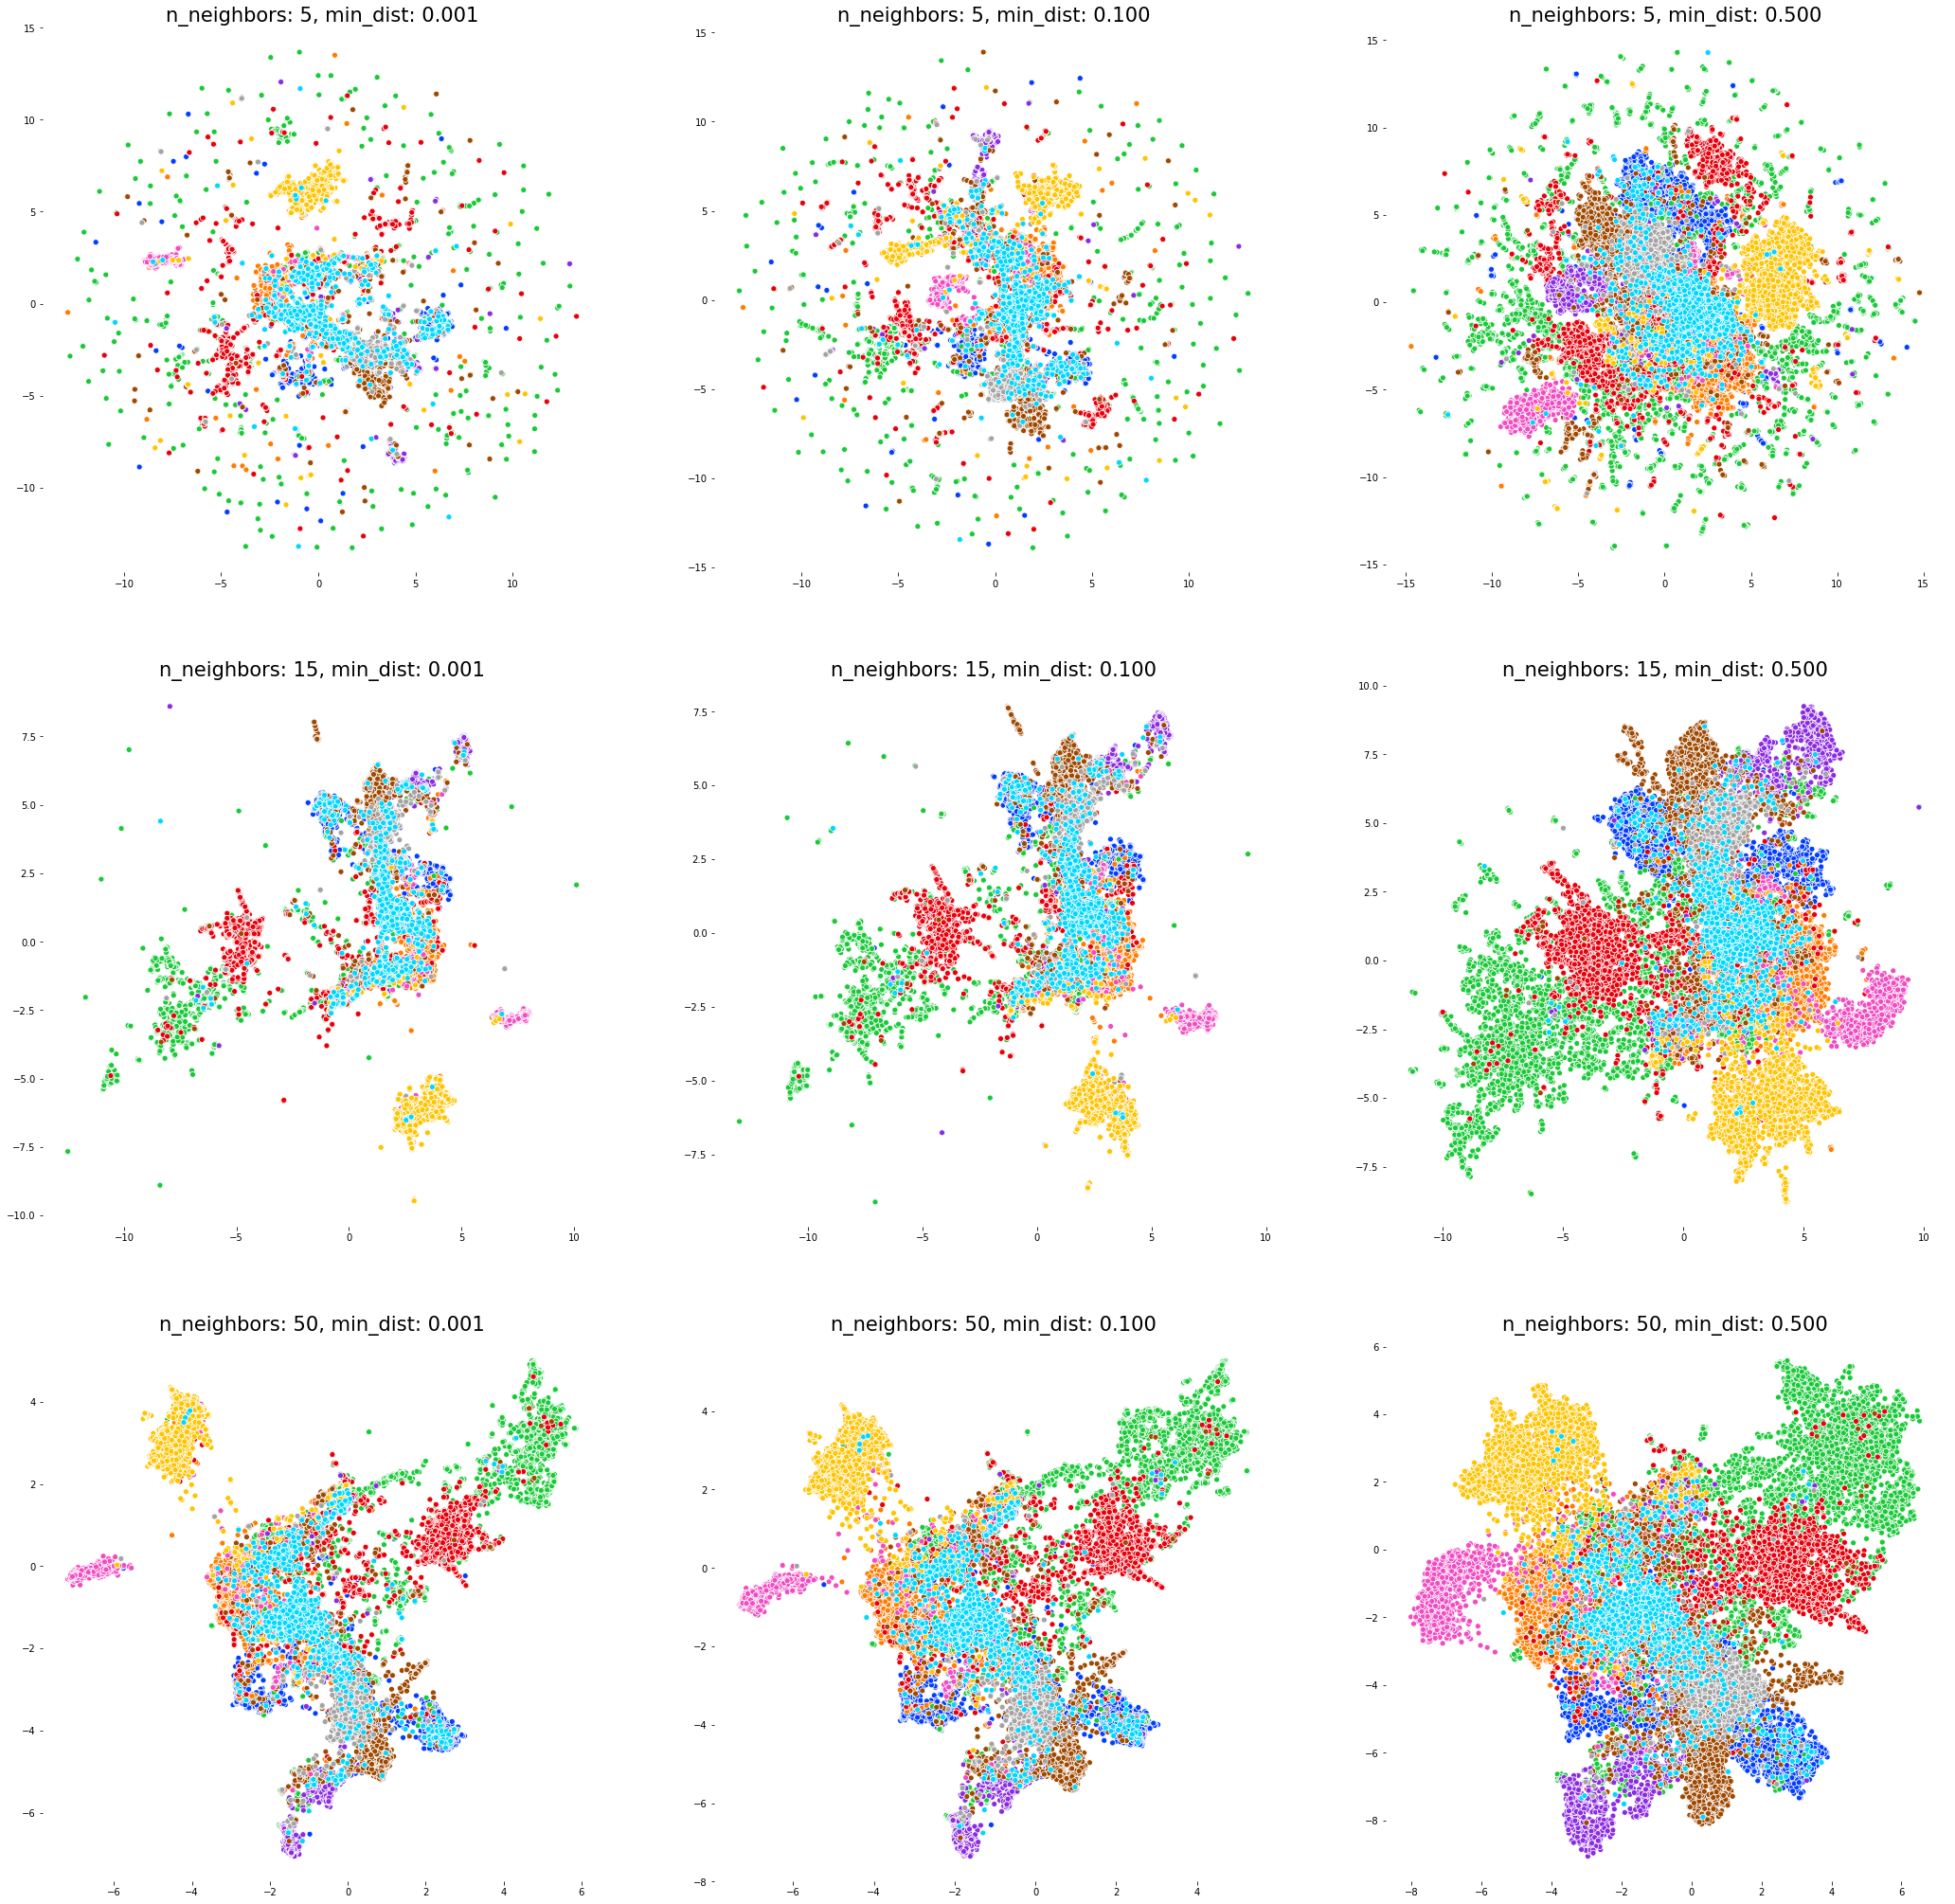

In [17]:
f, ax = plt.subplots(figsize=(36, 36), nrows=3, ncols=3)
ax = ax.flatten()
for (i, embeddings), (n_neighbors, min_dist) in zip(
    enumerate(X_umap.values()),
    itertools.product([5, 15, 50], [0.001, 0.1, 0.5])
):
    sns.despine(left=True, bottom=True)
    sns.scatterplot(
        x=embeddings[:, 0],
        y=embeddings[:, 1],
        hue=list(map(lambda x: map_labels[x], y)),
        palette=sns.color_palette('bright', 10),
        legend=False,
        ax=ax[i]
    )
    ax[i].set_title('n_neighbors: %d, min_dist: %.3f' % (
        n_neighbors, min_dist
    ), fontsize=21)

# Outliers and incorrectly labeled images

We have used `IsolationForest` to detect outliers in two-dimensional embeddings space. Since this is only a proof of concept, we have chosen a very low value for contamination parameter in order to get only a few images.

In [18]:
from sklearn.ensemble import IsolationForest

X_tsne_bird = X_tsne[50][y == 0]
isofor = IsolationForest(
    contamination=0.001,
    behaviour='new',
    random_state=7
)
isofor.fit(X_tsne_bird)

IsolationForest(behaviour='new', bootstrap=False, contamination=0.001,
        max_features=1.0, max_samples='auto', n_estimators=100,
        n_jobs=None, random_state=7, verbose=0)

Then, we have extracted an information about index of the image in order to be able to visualize it.

In [19]:
outliers = isofor.predict(X_tsne_bird)

outliers_idx = pd.DataFrame(y)\
    .iloc[y == 0, :]\
    .iloc[outliers == -1]\
    .index\
    .tolist()
print(f'Index of an outlier: {outliers_idx}')

Index of an outlier: [175]


Then, we have visualized our outlier. It turned out that it was a flamingo painted on an airplane. Well, at least both things fly.

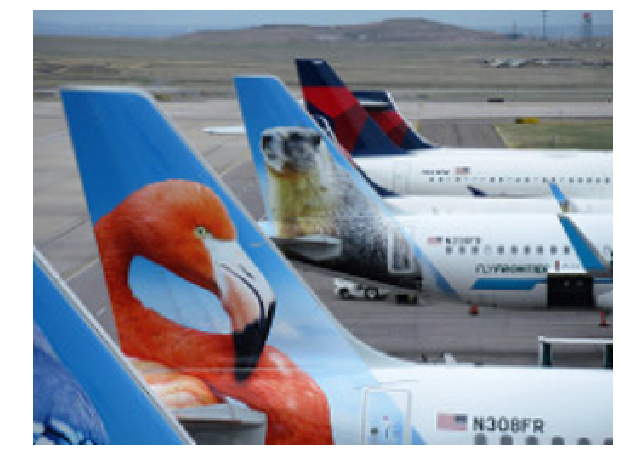

In [20]:
from torchvision import transforms
from tmle.dataloaders import ImageFoldersDataset

# define transformations
basic_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])
# define dataset
train_dataset = ImageFoldersDataset(
    path_to_data='../data/cpu/train/',
    transform=basic_transforms
)
# visualize
f, ax = plt.subplots(figsize=(12, 8))
ax.imshow(train_dataset.dataset[outliers_idx[0]][0]\
          .permute(1, 2, 0)\
          .numpy())
ax.axis('off')
plt.show()

```
TODO(lukasz): compare results obrained by ResNet across the entire dataset and on the dataset after outlier observations have been deleted.
```